In [4]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the training data into feature matrix, class labels, and event ids:

In [5]:
from proj1_helpers import *
from classifiers import *
from solver import *
from implementations import *

In [6]:
DATA_TRAIN_PATH = '../data/train.csv'
y, tX, ids, features = load_csv_data(DATA_TRAIN_PATH, sub_sample=True)

print(features)

['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_tau_pt', 'PRI_tau_eta', 'PRI_tau_phi', 'PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met', 'PRI_met_phi', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_leading_pt', 'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 'PRI_jet_subleading_pt', 'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_jet_all_pt']


## Do your thing crazy machine learning thing here :) ...

In [75]:
def tXToX(tX):
    X = np.c_[np.ones(tX.shape[0]), tX]

    X_safe = X
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            if X[i,j] < -990:
                X[i,j] = 0
    
    return X_safe

X = np.c_[np.ones(len(y)), tX]
n, d = X.shape

X_safe = tXToX(tX)

In [5]:
w_mse, loss_mse = least_squares(y, X)

In [6]:
accuracy_mse = compute_accuracy(predict_labels(w_mse, X), y)
print(accuracy_mse)

0.754


In [7]:
def ridge_classifier(lambda_):
    return ridge_regression(y, X, lambda_)

lambda_ridge, _, _ = find_max_hyperparam(ridge_classifier, [10**c for c in range(-3,3)])
print("Optimal lambda: %f" % lambda_ridge)

Testing hyperparameter value 0.001000 - loss: 0.326
Testing hyperparameter value 0.010000 - loss: 0.327
Testing hyperparameter value 0.100000 - loss: 0.332
Testing hyperparameter value 1.000000 - loss: 0.340
Testing hyperparameter value 10.000000 - loss: 0.345
Testing hyperparameter value 100.000000 - loss: 0.353
Optimal lambda: 0.001000


In [8]:
def ridge_train(y_train, X_train):
    return ridge_regression(y, X, lambda_ridge)

def ridge_test(X_test, w):
    return np.sign(X_test@w)

accuracy_ridge = cross_validate(y, X, ridge_train, ridge_test, 0.8, 100)
print(accuracy_ridge)

0.7539100000000001


In [64]:
def log_reg_train(y_train, X_train):
    return logistic_regression(y_train, X_train, 0.01*np.ones(X_train.shape[1]), 1000, verbose=False)

def log_reg_test(X_test, w):
    return np.sign(X_test@w)

accuracy_log_reg = cross_validate(y, X_safe, log_reg_train, log_reg_test, 0.7, 20)
print(accuracy_log_reg)

0.7397333333333334


In [89]:
def reg_log_reg_classifier(lambda_):
    return reg_logistic_regression(y, X_safe, lambda_, np.zeros(X_safe.shape[1]), 1000)

def log_reg_sparse_classifier(lambda_):
    return logistic_regression_sparse(y, X_safe, lambda_, np.zeros(X_safe.shape[1]), 1000)

def mse_sparse_classifier(lambda_):
    return least_squares_sparse(y, X_safe, lambda_, np.zeros(X_safe.shape[1]), 1000)

In [90]:
lambda_log_reg_l2, _, _ = find_max_hyperparam(reg_log_reg_classifier, [10**c for c in range(-3,3)])

Testing hyperparameter value 0.001000 - loss: 2524.940
Testing hyperparameter value 0.010000 - loss: 2517.906
Testing hyperparameter value 0.100000 - loss: 2508.234
Testing hyperparameter value 1.000000 - loss: 2507.569
Testing hyperparameter value 10.000000 - loss: 2518.794
Testing hyperparameter value 100.000000 - loss: 2521.077


In [92]:
lambda_log_reg_l1, _, _ = find_max_hyperparam(log_reg_sparse_classifier, [10**c for c in range(-3,3)])

Testing hyperparameter value 0.001000 - loss: 2517.383
Testing hyperparameter value 0.010000 - loss: 2533.131
Testing hyperparameter value 0.100000 - loss: 2528.486
Testing hyperparameter value 1.000000 - loss: 2547.096
Testing hyperparameter value 10.000000 - loss: 2537.588
Testing hyperparameter value 100.000000 - loss: 2576.245


In [99]:
lambda_mse_l2, _, _ = find_max_hyperparam(ridge_classifier, [10**c for c in range(-6,1)])

Testing hyperparameter value 0.000001 - loss: 0.325
Testing hyperparameter value 0.000010 - loss: 0.325
Testing hyperparameter value 0.000100 - loss: 0.325
Testing hyperparameter value 0.001000 - loss: 0.326
Testing hyperparameter value 0.010000 - loss: 0.327
Testing hyperparameter value 0.100000 - loss: 0.332
Testing hyperparameter value 1.000000 - loss: 0.340


In [101]:
lambda_mse_l1, w_mse_l1, _ = find_max_hyperparam(mse_sparse_classifier, [10**c for c in range(-6,1)])

Testing hyperparameter value 0.000001 - loss: 0.340
Testing hyperparameter value 0.000010 - loss: 0.338
Testing hyperparameter value 0.000100 - loss: 0.341
Testing hyperparameter value 0.001000 - loss: 0.339
Testing hyperparameter value 0.010000 - loss: 0.346
Testing hyperparameter value 0.100000 - loss: 0.354
Testing hyperparameter value 1.000000 - loss: 0.360


In [122]:
w_mse_l1, _ = least_squares_sparse(y, X_safe, 0.01, np.zeros(X_safe.shape[1]), 1000)
print("Non-zero weights: %i / %i" % (np.sum(w_mse_l1 != 0), len(w_mse_l1)))

Non-zero weights: 26 / 31


In [71]:
p = 1
ypred_kernel = kernel_predict(kernel_poly, y, X_safe, X_safe, p, lambda_=1)
print(compute_accuracy(ypred_kernel, y))

0.7554


# Visualisation

Linear Regression| Mean=0.753000 STD=0.012347
Logistic Regression| Mean=0.718800 STD=0.014428
L2 Logistic Regression| Mean=0.718800 STD=0.014428


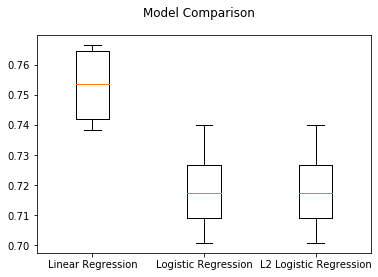

In [8]:
classifier = [('Linear Regression', LeastSquares()), 
          ('Logistic Regression', LogisticRegression()), 
          ('L2 Logistic Regression', LogisticRegressionL2())]
results, name = model_comparison(classifier,y,tX,4)

## Generate predictions and save ouput in csv format for submission:

In [72]:
DATA_TEST_PATH = '../data/test.csv'
y_test, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [ ]:
X_test_safe = tXToX(tX_test)

In [76]:
compute_accuracy(np.sign(X_test_safe @ w_mse_l1), y_test)

In [ ]:
OUTPUT_PATH = '../results/predictions.csv'
y_pred = predict_labels(weights, tX_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)